<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/root_cause_analysis/rag_with_citation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Root Cause Analysis</h1>

<h2 style="text-align: center;">RAG with Citation</h2>

**What is RAG?** RAG is the process of utilising external knowledge to your LLM-based application. 

For example: Imagine you have a knowledge document outlining various scenarios for handling customer refund requests. With an LLM-powered bot at your disposal, the goal is to provide users with accurate responses based on the information in the document.

You can store your knowledge base (context documents) in a Vector Database such as FAISS, QDrant or Chroma. Further, you can search for a chunk of information relevant to the question being asked from this Vector DB. You can then use this retrieved context to better answer the question. 

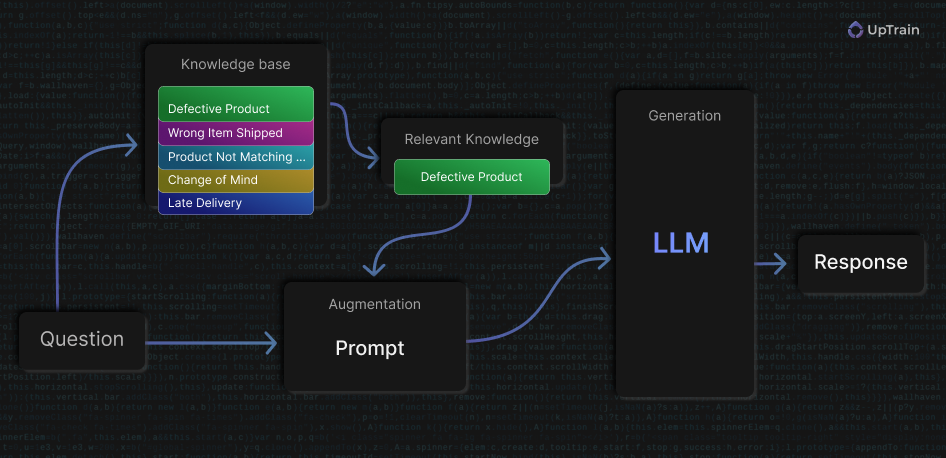

### Overview

In this tutorial we will walk you through Using UpTrain to perform RCA on your RAG pipeline.

UpTrain uses these 4 parameters to perform RCA on your RAG pipeline:

- `question`: This is the query asked by your user.
- `context`: This is the context retrieved from your Vector DB
- `response`: The response generated by the LLM
- `cited_context`: The relevant portion of the retrieved context that the LLM cites to generate response.

Please note that the `context` mentioned here is the context that you have retrieved from a Vector DB and not the context chunk (as it wouldn't be ideal performing an evaluation on the context chunk in a practical application due to its size). 

To further learn about the use of Vector DBs for your RAG pipeline, you can have a look at this [tutorial](https://github.com/uptrain-ai/uptrain/blob/main/examples/integrations/rag/rag_evaluations_uptrain_mistral.ipynb)

Through this tutorial we will try to walk you through the following failure cases possible in your RAG pipeline:
- *Poor Retrieval*: The context does not have information relevant to the question asked.
- *Poor Citation*: The cited information is not factually correct.
- *Poor Context Utilization*: The cited information is not relevant to the question
- *Hallucinations*: The generated response is not factually correct.

 If you face any difficulties, need some help with using UpTrain or want to brainstorm on custom evaluations for your use-case, [speak to the maintainers of UpTrain here](https://calendly.com/uptrain-sourabh/30min).

## Step 1: Install UpTrain

In [1]:
%pip install uptrain -qU

Note: you may need to restart the kernel to use updated packages.


## Step 2: Let's define our dataset to run evaluations upon

In this example we have created a dataset for a custom use-case in customer support queries.

Where the `question` is around a specific scenario of refund and the `context` is around different scenarios of refund possible.

In [2]:
data = [
    {
        'question': 'How much refund can I get for a defective product?',
        'context': 'Wrong Item Shipped: replacement. Late Delivery: 10% refund. Else: Talk to customer support agent.',
        'cited_context': 'Late Delivery: 10% refund.',
        'response': 'You are eligible for a 10% refund.'        
    },
    {
        'question': 'How much refund can I get for a defective product?',
        'context': 'Defective Product: 100% refund. Wrong Item Shipped: replacement. Late Delivery: 10% refund.',
        'cited_context': 'Defective Product: 10% refund',
        'response': 'You are eligible for a a 10% refund.'        
    },
    {
        'question': 'How much refund can I get for a defective product?',
        'context': 'Defective Product: 100% refund. Wrong Item Shipped: replacement. Late Delivery: 10% refund.',
        'cited_context': 'Wrong Item Shipped: replacement',
        'response': 'You are not eligible for a refund but we can replace your order.'        
    },
    {
        'question': 'How much refund can I get for a defective product?',
        'context': 'Defective Product: 100% refund. Wrong Item Shipped: replacement. Late Delivery: 10% refund.',
        'cited_context': '',
        'response': 'We dont provide any refunds'        
    }
]

## Step 3: Perform RCA using UpTrain

In [3]:
%pip show uptrain

Name: uptrain
Version: 0.6.7.post1
Summary: UpTrain - tool to evaluate LLM applications on aspects like factual accuracy, response quality, retrieval quality, tonality, etc.
Home-page: 
Author: 
Author-email: 
License: Apache-2.0
Location: /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages
Requires: aiolimiter, fsspec, httpx, lazy-loader, loguru, networkx, numpy, openai, pandas, plotly, polars, pydantic, pydantic-settings
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [4]:
from uptrain import RcaTemplate, EvalLLM
import json
import nest_asyncio
nest_asyncio.apply()

OPENAI_API_KEY = "sk-***********"  # Insert your OpenAI API key here

eval_llm = EvalLLM(openai_api_key=OPENAI_API_KEY)

res = eval_llm.perform_root_cause_analysis(
    data = data,
    rca_template = RcaTemplate.RAG_WITH_CITATION
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 4/4 [00:01<00:00,  2.26it/s]


## Step 4: Let's look at some of the results 

First Lets import pprint (for better formatting of outputs)

In [5]:
from pprint import pprint

#### Sample with Poor Retrieval Example

In the following example we can see that the `context` does not have any information on handling refunds where the customer receives a defective product. Reflecting that the quality of retrieved context to be poor and not sufficient to answer the user's query. 

In [6]:
pprint(res[0], indent=3)

{  'cited_context': 'Late Delivery: 10% refund.',
   'context': 'Wrong Item Shipped: replacement. Late Delivery: 10% refund. '
              'Else: Talk to customer support agent.',
   'error_mode': 'Poor Retrieval',
   'error_resolution_suggestion': 'Context Retrieval Pipeline needs '
                                  'improvement',
   'explanation_cited_context_relevance': '{\n'
                                          '    "Reasoning": "The given context '
                                          'can give some relevant answer for '
                                          "the given query but can't answer it "
                                          'completely. The context provides '
                                          'information about a 10% refund for '
                                          'late delivery, but it does not '
                                          'specify the refund amount for a '
                                          'defective product. Th

#### Sample with Poor Citation Example

In the following example we can see that the `context` does have relevant information on handling refunds but the LLM has cited incorrect information. Reflecting that the citation is poor. 

In [7]:
pprint(res[1], indent=3)

{  'cited_context': 'Defective Product: 10% refund',
   'context': 'Defective Product: 100% refund. Wrong Item Shipped: '
              'replacement. Late Delivery: 10% refund.',
   'error_mode': 'Poor citation',
   'error_resolution_suggestion': 'LLM is extracting facts from the context '
                                  'which are not cited correctly. Improve the '
                                  'citation quality of LLM by adding more '
                                  'instructions',
   'explanation_cited_context_relevance': '{\n'
                                          '    "Reasoning": "The given context '
                                          'can answer the given question '
                                          'completely because it provides '
                                          'specific information about the '
                                          'refund percentage for a defective '
                                          'product. This information

#### Sample with Poor Context Utilization Example

In the following example we can see that the `context` does have relevant information on handling refunds but the LLM has cited information with some other case which is not relevant to the user's query. Reflecting that the LLM has not utilized the retrieved context properly. 

In [8]:
pprint(res[2], indent=3)

{  'cited_context': 'Wrong Item Shipped: replacement',
   'context': 'Defective Product: 100% refund. Wrong Item Shipped: '
              'replacement. Late Delivery: 10% refund.',
   'error_mode': 'Poor Context Utilization',
   'error_resolution_suggestion': 'Add intermediary steps so as the LLM can '
                                  'better understand context and generate a '
                                  'complete response',
   'explanation_cited_context_relevance': '{\n'
                                          '    "Reasoning": "The given context '
                                          'does not contain any information '
                                          'about the refund amount for a '
                                          'defective product. It only mentions '
                                          'that a wrong item was shipped and a '
                                          'replacement is needed. This does '
                                         

#### Sample with Hallucinations Example

In the following example we can see that the `context` does have relevant information on handling refunds but the LLM has generated a response which is not grounded by this context. Reflecting that the LLM is generating hallucinated responses. 

In [9]:
pprint(res[3], indent=3)

{  'cited_context': '',
   'context': 'Defective Product: 100% refund. Wrong Item Shipped: '
              'replacement. Late Delivery: 10% refund.',
   'error_mode': 'Hallucinations',
   'error_resolution_suggestion': 'Add instructions to your LLM to adher to '
                                  'the context provide - Try tipping',
   'explanation_cited_context_relevance': '{\n'
                                          '    "Reasoning": "The given context '
                                          'does not contain any information '
                                          'about the refund policy for '
                                          'defective products. It does not '
                                          'provide any details about the '
                                          "company's return or refund "
                                          'policies. Hence, the extracted '
                                          "context doesn't contain any "
             